# Model selection: Selecting the optimal training strategy and regularization parameter using multi-view information

RegVelo offers flexible training strategies to accommodate different modeling preferences and data characteristics. The choice of strategy determines how strictly the model adheres to prior gene regulatory network (GRN) knowledge versus how much it learns from the data itself.

- In **hard** mode, the GRN structure is strictly fixed by prior knowledge, i.e. no new gene-TF interactions can be inferred.
- In **soft** mode, the model can propose new interactions based on observed data.
- In **soft_regularized** mode, we have a tunable regularization parameter $\lambda_2$, which penalizes large values in the Jacobian matrix of the regulatory ODE system. This encourages **sparse regulatory connections** by limiting strong TF–gene interactions, thus reducing overfitting to noise in the data.

These strategies are implemented through the ModelComparison class, which provides a convenient interface for model selection. It contains three key methods:

- `train()`: Trains RegVelo models under specified training strategies and $\lambda_2$ values. You can also define how many times to repeat each training configuration via `n_repeats` for robustness.
- `evaluate()`: Evaluates the models using biologically meaningful metrics, such as pseudotime correlation, stemness, terminal state identification (TSI), and cross-boundary correctness (CBC).
- `plot_results()`: Visualizes evaluation results across models, enabling users to select the best-performing configuration based on multiple biological views.

This notebook guides you through using the `ModelComparison` class to identify an optimal model setup for your dataset.

## Library import

In [ ]:
import numpy as np
import scanpy as sc
import cellrank as cr
import scvi
import scvelo as scv
from regvelo import ModelComparison # Import ModelComparison
import regvelo as rgv

# Initialize random seed
scvi.settings.seed = 0

# Data loading
adata = rgv.datasets.zebrafish_nc()
prior_net = rgv.datasets.zebrafish_grn()

# Preprocessing
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

adata = rgv.pp.preprocess_data(adata)
adata = rgv.pp.set_prior_grn(adata, prior_net)

adata

/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
[rank: 0] Seed set to 0
2025-06-14 10:26:43.084300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749889603.944575 1881418 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749889604.496365 1881418 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


AnnData object with n_obs × n_vars = 697 × 1008
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'is_tf', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'cell_type_colors', 'neighbors', 'velocity_params', 'regulators', 'targets', 'skeleton', 'network'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [2]:
def to_numeric_range(val):
    if '-' in val:
        start, end = map(float, val.split('-'))
        return (start + end) / 2
    else:
        return float(val)

adata.obs["stage_num"] = adata.obs["stage"].str.replace("ss", "", regex=False)
adata.obs["stage_num"] = adata.obs["stage_num"].apply(to_numeric_range)

adata.var["TF"] = adata.var["is_tf"]

Recommended preprocessing steps are available in [this tutorial](https://theislab.github.io/regvelo_reproducibility/zebrafish/1_ss3_analysis.html).

To evaluate model performance from different biological perspectives, we recommend computing side information before proceeding to training. This includes pseudotime, stemness scores, known terminal states, and lineage transitions.

## Side information overview
Several types of biological side information can be used for model evaluation. It is recommended to compute and attach these annotations to `adata.obs` before initializing the `ModelComparison` object.

### Pseudotime and stemness score.

- **Pseudotime** assigns a temporal progression to each cell, useful for evaluating the continuity of inferred trajectories.
- **Stemness score** quantifies how undifferentiated a cell is, often using similarity to stem-like profiles.

You can compute these using:
- Pseudotime: [CellRank DPT kernel](https://theislab.github.io/regvelo_reproducibility/cell_cycle/2_dpt.html)
- Stemness: [CellRank CytoTrace kernel](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/kernels/400_cytotrace.html)

You may also use your own custom methods. Just store the resulting scores in `adata.obs`.

These fields are optional unless you plan to evaluate models using pseudotime or stemness correlation.

In [ ]:
# Diffusion pseudotime computation
## In this step we consider a cell with stage_num 3 as root cell. You can also use other methods to refer to your root cell.
root_cell_name = adata.obs[adata.obs['stage_num'] == 3.0].index[0] # Get cell name
root_ix = np.where(adata.obs_names == root_cell_name)[0][0] # Get cell index
adata.uns["iroot"] = root_ix
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

# Stemness score computation
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
kernel = 0.8 * vk + 0.2 * ck
ctk = cr.kernels.CytoTRACEKernel(adata).compute_cytotrace()
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

CytoTRACEKernel[n=697, dnorm=False, scheme='soft', b=10.0, nu=0.5]

In [4]:
adata.obs['stage']

CellID
nc01_zumi:AAGAGGCAAGAGGATAx    21-22ss
nc01_zumi:AAGAGGCAAGGCTTAGx    21-22ss
nc01_zumi:AAGAGGCAATAGCCTTx    21-22ss
nc01_zumi:AAGAGGCACGGAGAGAx    21-22ss
nc01_zumi:AAGAGGCATATGCAGTx    21-22ss
                                ...   
nc08_zumi:TCGACGTCATAGCCTTx    17-18ss
nc08_zumi:TCGACGTCATTAGACGx    12-13ss
nc08_zumi:TCGACGTCTACTCCTTx    12-13ss
nc08_zumi:TCGACGTCTATGCAGTx    17-18ss
nc08_zumi:TCGACGTCTCTTACGCx    17-18ss
Name: stage, Length: 697, dtype: category
Categories (6, object): ['3ss', '6-7ss', '10ss', '12-13ss', '17-18ss', '21-22ss']

### Terminal states and transition.

The following information is optional, but required if you plan to evaluate models using TSI or CBC metrics.

- `terminal_states` : A list of terminal cell types (as strings), provided manually. Required for **TSI** evaluation.
- `n_states` : The number of macrostates. Also required for **TSI** evaluation.  
  See details [here](https://theislab.github.io/regvelo_reproducibility/pancreatic_endocrinogenesis/3_comparison_tsi.html).

- `state_transition` : A list of (source, target) cell-type pairs (as strings) representing known state transitions.  
  Required for **CBC** evaluation.

If not using TSI or CBC, these fields are not necessary.

In [5]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

n_STATES = 8

STATE_TRANSITION = (('3.0','6.5'),
                    ('6.5','10.0'),
                    ('10.0', '12.5'),
                    ('12.5','17.5'),
                    ('17.5','21.5'))

## ModelComparison: Object initialization

We now initialize the `ModelComparison` object. If applicable, specify the following parameters:

- `terminal_states`
- `state_transition`
- `n_states`

In [6]:
comp = ModelComparison(terminal_states=TERMINAL_STATES, state_transition=STATE_TRANSITION, n_states=n_STATES)

## ModelComparison: Train.

In this step, we train models based on the strategies specified in `model_list`.

- **Hard mode**: Only uses the prior GRN—no new interactions allowed.
- **Soft mode**: Allows learning new gene–TF interactions from data.
- **Soft_regularized mode**: Applies Jacobian-based regularization to promote sparsity in regulatory influences. The parameter $\lambda_2$ penalizes large entries in the Jacobian matrix, encouraging fewer TF-gene connections.

You can specify multiple $\lambda_2$ values and repeat training for each setup using `n_repeats`.  

:::{note} Increasing `n_repeats` improves robustness but also increases runtime.

In [7]:
comp.train(adata,
           model_list=['soft','hard','soft_regularized'],
           lam2=[0.3,0.5,0.8],
           n_repeat=3)

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2693.205. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 2


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2518.802. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 0


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2762.689. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2097.244. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 2


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2070.044. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 0


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2205.542. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2607.447. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2487.559. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2308.303. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2464.967. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2326.849. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 2


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2300.450. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2657.179. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2428.583. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:4

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


['soft_0',
 'soft_1',
 'soft_2',
 'hard_0',
 'hard_1',
 'hard_2',
 'soft_regularized\nlam2:0.3_0',
 'soft_regularized\nlam2:0.5_0',
 'soft_regularized\nlam2:0.8_0',
 'soft_regularized\nlam2:0.3_1',
 'soft_regularized\nlam2:0.5_1',
 'soft_regularized\nlam2:0.8_1',
 'soft_regularized\nlam2:0.3_2',
 'soft_regularized\nlam2:0.5_2',
 'soft_regularized\nlam2:0.8_2']

['soft_0',
 'soft_1',
 'soft_2',
 'hard_0',
 'hard_1',
 'hard_2',
 'soft_regularized\nlam2:0.3_0',
 'soft_regularized\nlam2:0.5_0',
 'soft_regularized\nlam2:0.8_0',
 'soft_regularized\nlam2:0.3_1',
 'soft_regularized\nlam2:0.5_1',
 'soft_regularized\nlam2:0.8_1',
 'soft_regularized\nlam2:0.3_2',
 'soft_regularized\nlam2:0.5_2',
 'soft_regularized\nlam2:0.8_2']

## ModelComparison: Evaluate and Plot.

Once trained, all models are stored in the `ModelComparison` object. You can evaluate them across five different biological perspectives using the `evaluate()` method.

After evaluation, use `plot_results()` to visualize the performance of each model. The plots include:

- A barplot of scores across models
- Statistical significance bars comparing the top-performing model with others  (*Only shown when* `n_repeats >= 3` *and p-value < 0.05*)

This step helps to identify which training strategy and regularization setting yields the most biologically meaningful results.

### Real time

If you know the actual cell types and their expected temporal ordering, use **'Real_Time'** evaluation mode.

- Specify the `side_key` in `adata.obs` containing a continuous variable (e.g., true developmental time).
- Spearman correlation will be computed between this variable and the model’s inferred latent time.

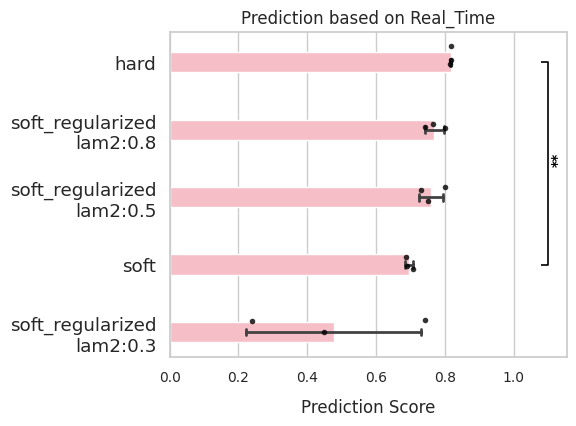

In [8]:
comp.evaluate(side_information='Real_Time',
              side_key='stage_num')
comp.plot_results(side_information='Real_Time')

### Pseudo time

If pseudotime has been computed (e.g., via DPT or any other method), use **'Pseudo_Time'** evaluation mode.

- By default, the key used is `'dpt_pseudotime'` in `adata.obs`.
- You can override this by setting `side_key` to another continuous annotation.

Evaluation is based on the Spearman correlation between RegVelo-inferred latent time and the provided pseudotime.

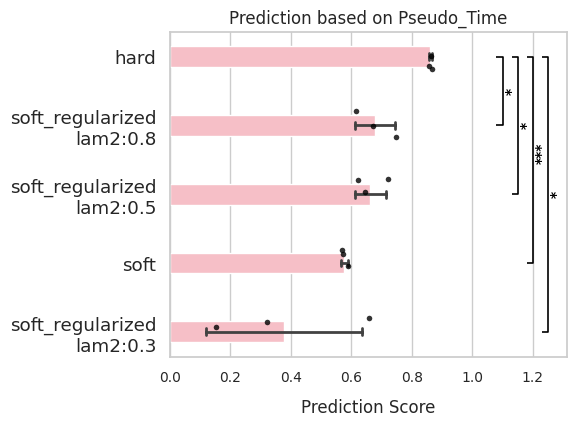

In [9]:
comp.evaluate(side_information='Pseudo_Time')
comp.plot_results(side_information='Pseudo_Time')

### Stemness score

To assess how well the model preserves undifferentiated cell states, use **'Stemness_Score'** mode.

- By default, `side_key = 'ct_score'`, corresponding to CytoTrace-based stemness estimates in `adata.obs`.
- You may provide your own custom stemness score by assigning a different `side_key`.

As with pseudotime, this mode evaluates the correlation between latent time and the given stemness measure.

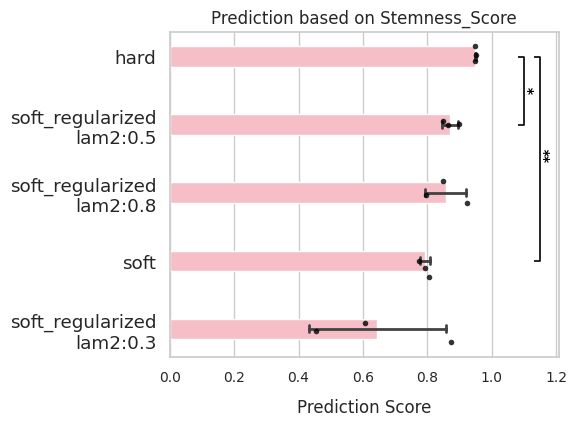

In [10]:
comp.evaluate(side_information='Stemness_Score')
comp.plot_results(side_information='Stemness_Score')

### TSI (Terminal state identification)
TSI measures how well the model predicts terminal states. To learn more, please refer to [here](https://cellrank.readthedocs.io/en/latest/api/_autosummary/estimators/cellrank.estimators.GPCCA.html#tsi).

- Evaluation requires terminal states and the number of macrostates (`n_states`) to be provided during initialization.
- You must also provide a `side_key` that defines clusters in `adata.obs`.

The TSI score is computed using CellRank’s `GPCCA.tsi(cluster_key=side_key)` method.

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

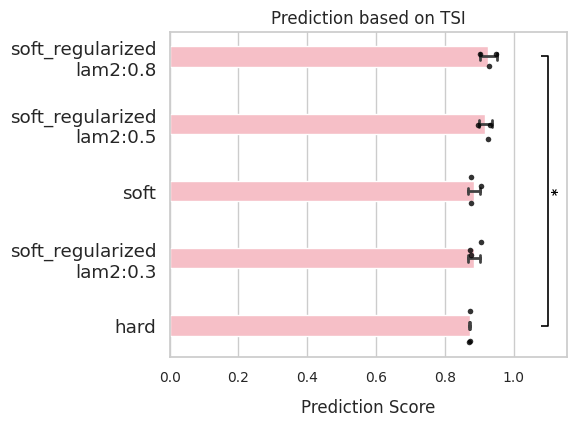

In [11]:
comp.evaluate(side_information='TSI',
              side_key='cell_type')
comp.plot_results(side_information='TSI')

### CBC (Cross boundary correctness)

CBC evaluates whether the model’s inferred transitions align with known biological state changes. To learn more, please refer to [here](https://cellrank.readthedocs.io/en/stable/api/developer.html#cellrank.kernels.Kernel.cbc).

- Required inputs are:
  - `state_transition` (list of known transitions)
  - `side_key` (cell-type annotations in `adata.obs`)
- `side_key` can be a string or numeric series—it will be converted to categorical labels.

The CBC score is calculated using CellRank’s `kernels.kernel.cbc(cluster_key=side_key)` method.

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

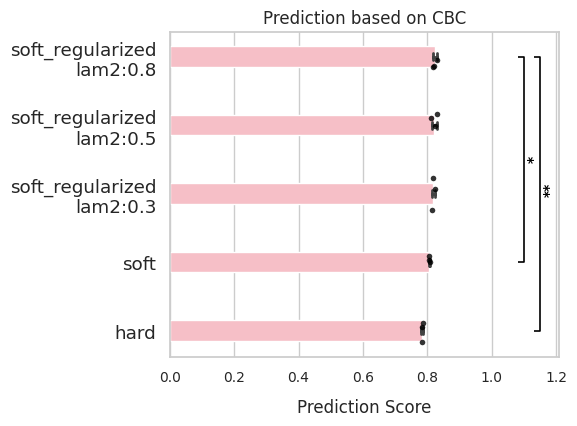

In [12]:
comp.evaluate(side_information='CBC',
              side_key = 'stage_num')
comp.plot_results(side_information='CBC')

## Summary and next steps

In this notebook, we demonstrated how to use RegVelo’s `ModelComparison` class to select optimal training strategies and regularization parameters based on multi-view biological information. By combining quantitative evaluation metrics, such as pseudotime correlation, stemness score, TSI, and CBC, we identified models that best capture the underlying cellular dynamics.

### Key takeaways
- RegVelo supports flexible GRN integration strategies: **hard**, **soft**, and **soft_regularized**.
- Biological side information (e.g., pseudotime, cell types, lineage transitions) helps to assess model quality.
- The `ModelComparison` class integrates training, evaluation, and visualization across multiple settings.

### Next Steps
- Use the selected model for downstream applications such as fate prediction or perturbation analysis.
- Explore other datasets and adjust $\lambda_2$ to match system-specific dynamics.
- Extend evaluation using additional side information or custom metrics relevant to your biological question.